#  Notebook: 2-supervised-classification

Accompanying the paper:<br>
A. J. Lundervold, ..., A. Lundervold. _Decoding IBS: A Machine Learning Approach to Psychological Distress and Gut-Brain Interaction_

Arvid Lundervold, v. 2024-07-21  - using conda kernel `ibs` (Python 3.11.9))

Last updated: 2024-07-22

## Import libraries

In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
import pandas as pd
import pyreadstat
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import pycaret
import ydata_profiling
from ydata_profiling import ProfileReport
import platform
import shutil
import warnings
import datetime
import pingouin as pg
import xgboost as xgb
from pycaret.classification import *
from pycaret.regression import *
from pycaret.clustering import *
from pycaret.anomaly import *
from sklearn.gaussian_process import GaussianProcessClassifier as gpc
from sklearn.gaussian_process.kernels import RBF

# import MLP from scikit-learn  
from sklearn.neural_network import MLPClassifier
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
import scikitplot as skplt
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

import shap

home = os.path.expanduser('~')

In [3]:
if platform.system() == 'Darwin':
    print(f'OK, you are running on MacOS ({platform.version()})')
if platform.system() == 'Linux':
    print(f'OK, you are running on Linux ({platform.version()})')
if platform.system() == 'Windows':
    print(f'OK, but consider to install WSL for Windows10/11 since you are running on {platform.system()}')
    print('Check https://docs.microsoft.com/en-us/windows/wsl/install')

OK, you are running on MacOS (Darwin Kernel Version 23.5.0: Wed May  1 20:09:52 PDT 2024; root:xnu-10063.121.3~5/RELEASE_X86_64)


In [4]:
# OPTIONAL: Extensive exploration using `ydata-profiling`

PROFILING = False

In [5]:
# Versions

print(f'seaborn: {sns.__version__}')
print(f'pandas: {pd.__version__}')
print(f'pycaret: {pycaret.__version__}')
print(f'ydata_profiling: {ydata_profiling.__version__}')
print(f'pingouin: {pg.__version__}')
print(f'xgboost: {xgb.__version__}')
print(f'scikit-learn: {sklearn.__version__}')
print(f'shap: {shap.__version__}')
print(f'scikit-plot: {skplt.__version__}')

seaborn: 0.13.2
pandas: 2.1.4
pycaret: 3.3.2
ydata_profiling: v4.9.0
pingouin: 0.5.4
xgboost: 2.1.0
scikit-learn: 1.4.2
shap: 0.46.0
scikit-plot: 0.3.7


## Read reduced dataset, rename columns, and inspect the data

In [6]:
# Load the CSV file
df_in = pd.read_csv('../data/BGA_for_classification_77x13.csv')

In [7]:
df_in = df_in.rename(columns = {'Category':'Group'})

In [8]:
df_in.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77 entries, 0 to 76
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BGA      77 non-null     object 
 1   Sex      77 non-null     object 
 2   Age      77 non-null     float64
 3   IBS-SSS  77 non-null     float64
 4   R1       77 non-null     float64
 5   R2       77 non-null     float64
 6   B1       77 non-null     float64
 7   B2       77 non-null     float64
 8   H1       77 non-null     float64
 9   H2       77 non-null     float64
 10  F1       77 non-null     float64
 11  F2       77 non-null     float64
 12  Group    77 non-null     object 
dtypes: float64(10), object(3)
memory usage: 7.9+ KB


In [9]:
df_in

,BGA,Sex,Age,IBS-SSS,R1,R2,B1,B2,H1,H2,F1,F2,Group
0,BGA_046,M,38.0,195.0,37.0,63.0,3.0,13.0,1.0,4.0,3.0,0.0,IBS
1,BGA_051,M,38.0,293.0,36.0,71.0,8.0,4.0,2.0,3.0,5.0,0.0,IBS
2,BGA_057,F,30.0,264.0,35.0,63.0,14.0,20.0,7.0,1.0,6.0,2.0,IBS
3,BGA_058,F,57.0,296.0,37.0,51.0,8.0,12.0,7.0,7.0,7.0,4.0,IBS
4,BGA_059,F,43.0,364.0,30.0,55.0,7.0,6.0,13.0,6.0,1.0,1.0,IBS
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,BGA_160,F,23.0,265.0,20.0,46.0,11.0,13.0,12.0,4.0,4.0,1.0,IBS
73,BGA_161,F,21.0,393.0,35.0,51.0,0.0,3.0,8.0,1.0,5.0,2.0,IBS
74,BGA_164,F,25.0,12.0,40.0,66.0,2.0,3.0,11.0,7.0,3.0,0.0,HC
75,BGA_171,M,21.0,32.0,35.0,66.0,3.0,13.0,8.0,2.0,2.0,1.0,HC


In [10]:
print('Age distribution:')
df_in.groupby(['Sex', 'Group']).Age.describe().round(3)

Age distribution:


count    mean     std   min    25%   50%    75%   max
Sex Group                                                       
F   HC      18.0  34.778  13.027  20.0  23.00  30.5  46.00  58.0
    IBS     38.0  36.369  11.976  19.0  27.25  36.0  42.75  61.0
M   HC      10.0  35.200  11.717  21.0  26.75  35.5  39.75  58.0
    IBS     11.0  36.636   6.845  28.0  31.50  35.0  40.50  48.0

In [11]:
df_M_IBS = df_in[(df_in['Age'] > 0.0) & ~(df_in['Sex'] == 'F') & (df_in['Group'] == 'IBS')]
imp_mean = df_M_IBS.Age.values.mean().round(1)
print(list(df_M_IBS.Age), '-> Mean age:', imp_mean)

[38.0, 38.0, 31.0, 35.0, 28.0, 30.0, 33.0, 47.0, 48.0, 43.0, 32.0] -> Mean age: 36.6


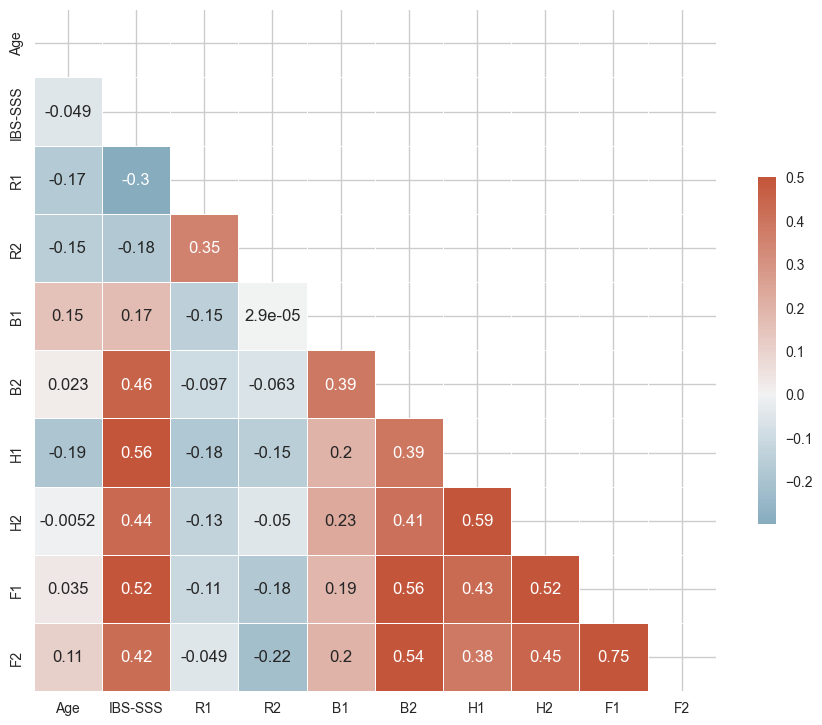

In [12]:
# Compute the correlation matrix

df_X = df_in.drop(['BGA'], axis=1)
# Select Only Numeric Columns in Pandas
df_X = df_X.select_dtypes(include=np.number)
corr = df_X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

## Using PyCaret

We use PyCaret to automatically prepare the data for us (using the default settings of the setup function):

Seen as a **classification problem**

**Predictors (X):** R1, R2, B1, B2, H1, H2, F1, F2<br>
**Target (y):** Group (IBS or HC)

In [13]:
#col_keep = ['Sex', 'Age', 'R1', 'R2', 'B1', 'B2', 'H1', 'H2', 'F1', 'F2', 'Group']
col_keep = ['R1', 'R2', 'B1', 'B2', 'H1', 'H2', 'F1', 'F2', 'Group']


df = df_in.copy()
df = df_in[col_keep]
df.describe()

,R1,R2,B1,B2,H1,H2,F1,F2
count,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000,77.000000
mean,33.909091,59.701299,5.220779,9.168831,6.571429,3.753247,3.285714,1.259740
std,5.145723,8.669464,4.109115,4.985248,4.290223,3.116830,2.689439,1.408644
min,14.000000,35.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,54.000000,2.000000,5.000000,3.000000,1.000000,0.000000,0.000000
50%,35.000000,60.000000,4.000000,9.000000,6.000000,4.000000,4.000000,1.000000
75%,37.000000,66.000000,8.000000,13.000000,9.000000,6.000000,6.000000,2.000000
max,42.000000,82.000000,16.000000,21.000000,17.000000,14.000000,7.000000,4.000000


Count unique values in each column

In [14]:
df.nunique()

R1       20
R2       32
B1       15
B2       20
H1       16
H2       12
F1        8
F2        5
Group     2
dtype: int64

In [15]:
from pycaret.classification import *

In [16]:
experiment = setup(data = df, target = 'Group', session_id=123)   # session_id is similar at random_state in scikit-learn 

,Description,Value
0,Session id,123
1,Target,Group
2,Target type,Binary
3,Target mapping,"HC: 0, IBS: 1"
4,Original data shape,"(77, 9)"
5,Transformed data shape,"(77, 9)"
6,Transformed train set shape,"(53, 9)"
7,Transformed test set shape,"(24, 9)"
8,Numeric features,8
9,Preprocess,True


In [17]:
# List available classsifiers   
models()

,Name,Reference,Turbo
ID,,,
lr,Logistic Regression,sklearn.linear_model._logistic.LogisticRegression,True
knn,K Neighbors Classifier,sklearn.neighbors._classification.KNeighborsCl...,True
nb,Naive Bayes,sklearn.naive_bayes.GaussianNB,True
dt,Decision Tree Classifier,sklearn.tree._classes.DecisionTreeClassifier,True
svm,SVM - Linear Kernel,sklearn.linear_model._stochastic_gradient.SGDC...,True
rbfsvm,SVM - Radial Kernel,sklearn.svm._classes.SVC,False
gpc,Gaussian Process Classifier,sklearn.gaussian_process._gpc.GaussianProcessC...,False
mlp,MLP Classifier,sklearn.neural_network._multilayer_perceptron....,False
ridge,Ridge Classifier,sklearn.linear_model._ridge.RidgeClassifier,True


**Here's the data after the transformations found above have been applied:**

### **Training set**

In [18]:
get_config('X_train').T

,74,21,50,51,55,1,31,73,0,41,...,12,30,23,61,67,59,4,17,38,60
R1,40.0,32.0,35.0,14.0,27.0,36.0,42.0,35.0,37.0,39.0,...,42.0,32.0,41.0,30.0,37.0,24.0,30.0,40.0,33.0,33.0
R2,66.0,60.0,66.0,35.0,60.0,71.0,66.0,51.0,63.0,64.0,...,70.0,68.0,65.0,51.0,66.0,45.0,55.0,58.0,50.0,60.0
B1,2.0,0.0,1.0,9.0,2.0,8.0,3.0,0.0,3.0,5.0,...,8.0,11.0,1.0,9.0,9.0,4.0,7.0,2.0,0.0,1.0
B2,3.0,1.0,7.0,11.0,14.0,4.0,12.0,3.0,13.0,11.0,...,7.0,19.0,4.0,7.0,13.0,4.0,6.0,5.0,10.0,4.0
H1,11.0,0.0,6.0,12.0,9.0,2.0,13.0,8.0,1.0,9.0,...,3.0,10.0,2.0,4.0,7.0,8.0,13.0,1.0,0.0,0.0
H2,7.0,0.0,3.0,6.0,4.0,3.0,5.0,1.0,4.0,7.0,...,2.0,14.0,1.0,1.0,1.0,4.0,6.0,0.0,1.0,1.0
F1,3.0,0.0,0.0,7.0,2.0,5.0,5.0,5.0,3.0,5.0,...,1.0,7.0,0.0,4.0,7.0,5.0,1.0,0.0,4.0,2.0
F2,0.0,0.0,0.0,4.0,1.0,0.0,2.0,2.0,0.0,2.0,...,0.0,2.0,0.0,2.0,3.0,2.0,1.0,0.0,0.0,0.0


In [19]:
print("Group:", list(get_config('y_train')))

Group: ['HC', 'HC', 'HC', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'HC', 'HC', 'HC', 'HC', 'HC', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'HC', 'HC', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'HC', 'IBS', 'IBS', 'IBS', 'IBS', 'HC', 'HC', 'HC']


In [20]:
get_config('X_train').info()

<class 'pandas.core.frame.DataFrame'>
Index: 53 entries, 74 to 60
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   R1      53 non-null     float32
 1   R2      53 non-null     float32
 2   B1      53 non-null     float32
 3   B2      53 non-null     float32
 4   H1      53 non-null     float32
 5   H2      53 non-null     float32
 6   F1      53 non-null     float32
 7   F2      53 non-null     float32
dtypes: float32(8)
memory usage: 2.1 KB


### **Test set**

In [21]:
get_config('X_test').T

,62,57,28,3,20,5,65,47,7,36,...,34,10,72,49,46,66,58,8,75,9
R1,35.0,27.0,39.0,37.0,40.0,32.0,37.0,28.0,33.0,35.0,...,31.0,32.0,20.0,28.0,39.0,30.0,34.0,38.0,35.0,41.0
R2,60.0,59.0,45.0,51.0,55.0,72.0,52.0,65.0,59.0,55.0,...,70.0,61.0,46.0,67.0,67.0,63.0,50.0,74.0,66.0,68.0
B1,4.0,7.0,6.0,8.0,2.0,5.0,1.0,6.0,0.0,3.0,...,1.0,5.0,11.0,5.0,1.0,3.0,3.0,11.0,3.0,3.0
B2,2.0,4.0,9.0,12.0,4.0,10.0,5.0,10.0,5.0,11.0,...,1.0,14.0,13.0,8.0,7.0,4.0,6.0,10.0,13.0,9.0
H1,3.0,6.0,5.0,7.0,3.0,7.0,4.0,1.0,3.0,13.0,...,5.0,4.0,12.0,2.0,9.0,13.0,6.0,5.0,8.0,3.0
H2,1.0,7.0,0.0,7.0,1.0,4.0,1.0,1.0,1.0,4.0,...,4.0,7.0,4.0,4.0,4.0,9.0,7.0,6.0,2.0,0.0
F1,0.0,4.0,6.0,7.0,0.0,7.0,0.0,6.0,0.0,5.0,...,0.0,5.0,4.0,0.0,2.0,6.0,5.0,1.0,2.0,0.0
F2,0.0,0.0,2.0,4.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,3.0,1.0,1.0,3.0,2.0,2.0,0.0,1.0,0.0


In [22]:
print("Group:", list(get_config('y_test')))

Group: ['IBS', 'IBS', 'HC', 'IBS', 'HC', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'IBS', 'HC', 'IBS', 'IBS', 'HC', 'HC', 'HC']


In [23]:
# Count the number of samples in the full data set by group
print(f"Full data: {df.groupby('Group').size()}")

# Count the number of samples in the training set by group
df_train = get_config('X_train')
df_train['Group'] = get_config('y_train')
df_train['Index'] = df_train.index
df_train['BGA'] = df_in['BGA'][df_train['Index']]
df_train['Sex'] = df_in['Sex'][df_train['Index']]
# Renumber index
df_train = df_train.reset_index(drop=True)
print(f"\nTraining data: {df_train.groupby('Group').size()}")
print(f"\nTraining data: {df_train.groupby('Sex').size()}")


# Count the number of samples in the test set by group
df_test = get_config('X_test')
df_test['Group'] = get_config('y_test')
df_test['Index'] = df_test.index
df_test['BGA'] = df_in['BGA'][df_test['Index']]
df_test['Sex'] = df_in['Sex'][df_test['Index']]
# Renumber index
df_test = df_test.reset_index(drop=True)
print(f"\nTest data: {df_test.groupby('Group').size()}")
print(f"\nTest data: {df_test.groupby('Sex').size()}")


Full data: Group
HC     28
IBS    49
dtype: int64

Training data: Group
HC     19
IBS    34
dtype: int64

Training data: Sex
F    38
M    15
dtype: int64

Test data: Group
HC      9
IBS    15
dtype: int64

Test data: Sex
F    18
M     6
dtype: int64


In [24]:
df_test

,R1,R2,B1,B2,H1,H2,F1,F2,Group,Index,BGA,Sex
0,35.0,60.0,4.0,2.0,3.0,1.0,0.0,0.0,IBS,62,BGA_148,F
1,27.0,59.0,7.0,4.0,6.0,7.0,4.0,0.0,IBS,57,BGA_143,F
2,39.0,45.0,6.0,9.0,5.0,0.0,6.0,2.0,HC,28,BGA_090,F
3,37.0,51.0,8.0,12.0,7.0,7.0,7.0,4.0,IBS,3,BGA_058,F
4,40.0,55.0,2.0,4.0,3.0,1.0,0.0,0.0,HC,20,BGA_079,F
5,32.0,72.0,5.0,10.0,7.0,4.0,7.0,3.0,IBS,5,BGA_060,F
6,37.0,52.0,1.0,5.0,4.0,1.0,0.0,0.0,IBS,65,BGA_151,F
7,28.0,65.0,6.0,10.0,1.0,1.0,6.0,0.0,IBS,47,BGA_128,F
8,33.0,59.0,0.0,5.0,3.0,1.0,0.0,0.0,HC,7,BGA_064,F
9,35.0,55.0,3.0,11.0,13.0,4.0,5.0,0.0,IBS,36,BGA_101,F


## Modelling

## Train some base models

Let's find the top performing models from those in PyCaret:

The function `compare_models()` trains and evaluates performance of all estimators available in the  model library using cross validation. The output of this function is a score grid  with average cross validated scores. Metrics evaluated during CV can be accessed using the ``get_metrics`` function. Custom metrics can be added or removed using 
``add_metric`` and ``remove_metric`` function.

The `sort order` of the score grid (default is `Accuracy`). It also accepts custom metrics that are added through the ``add_metric`` function.

In [25]:
help(compare_models)

Help on function compare_models in module pycaret.classification.functional:

compare_models(include: Optional[List[Union[str, Any]]] = None, exclude: Optional[List[str]] = None, fold: Union[int, Any, NoneType] = None, round: int = 4, cross_validation: bool = True, sort: str = 'Accuracy', n_select: int = 1, budget_time: Optional[float] = None, turbo: bool = True, errors: str = 'ignore', fit_kwargs: Optional[dict] = None, groups: Union[str, Any, NoneType] = None, experiment_custom_tags: Optional[Dict[str, Any]] = None, probability_threshold: Optional[float] = None, engine: Optional[Dict[str, str]] = None, verbose: bool = True, parallel: Optional[pycaret.internal.parallel.parallel_backend.ParallelBackend] = None) -> Union[Any, List[Any]]
    This function trains and evaluates performance of all estimators available in the
    model library using cross validation. The output of this function is a score grid
    with average cross validated scores. Metrics evaluated during CV can be access

## Table 3: Model comparisons and their metrics

In [26]:
%%time

# Omit the AUC metric in setup (remove_metric('AUC')) and compare_models)

best_model = compare_models()


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
rf,Random Forest Classifier,0.9100,0.9708,0.9100,0.9256,0.9067,0.8008,0.8182,0.0290
nb,Naive Bayes,0.8933,0.9250,0.8933,0.9200,0.8895,0.7741,0.7975,0.0070
gbc,Gradient Boosting Classifier,0.8733,0.8542,0.8733,0.8972,0.8662,0.7124,0.7427,0.0170
et,Extra Trees Classifier,0.8733,0.9375,0.8733,0.8994,0.8686,0.7220,0.7501,0.0290
lr,Logistic Regression,0.8533,0.9583,0.8533,0.8800,0.8495,0.6908,0.7141,0.8200
qda,Quadratic Discriminant Analysis,0.8533,0.8917,0.8533,0.8238,0.8175,0.6234,0.6490,0.0070
ada,Ada Boost Classifier,0.8400,0.9083,0.8400,0.8617,0.8381,0.6612,0.6779,0.0160
lightgbm,Light Gradient Boosting Machine,0.8333,0.9479,0.8333,0.8254,0.8174,0.6295,0.6443,0.0460
dt,Decision Tree Classifier,0.8167,0.8042,0.8167,0.8506,0.8114,0.6034,0.6378,0.1390
ridge,Ridge Classifier,0.8167,0.9375,0.8167,0.8417,0.8129,0.6100,0.6328,0.0070


CPU times: user 2.68 s, sys: 427 ms, total: 3.1 s
Wall time: 17.2 s


Copy and paste the table above into ChatGPT-4, asking to make a LaTeX table with 3 decimals:

```latex
\begin{table}[H]
\centering
\begin{tabular}{lllllllll}
\hline
Model & Classifier & Accuracy & Recall & Prec. & F1 & Kappa & MCC & TT (Sec) \\ \hline
rf & Random Forest Classifier & 0.910 & 0.910 & 0.926 & 0.907 & 0.801 & 0.818 & 0.016 \\
nb & Naive Bayes & 0.893 & 0.893 & 0.920 & 0.889 & 0.774 & 0.798 & 0.004 \\
gbc & Gradient Boosting Classifier & 0.873 & 0.873 & 0.897 & 0.866 & 0.712 & 0.743 & 0.011 \\
et & Extra Trees Classifier & 0.873 & 0.873 & 0.899 & 0.869 & 0.722 & 0.750 & 0.017 \\
lr & Logistic Regression & 0.853 & 0.853 & 0.880 & 0.849 & 0.691 & 0.714 & 0.134 \\
qda & Quadratic Discriminant Analysis & 0.853 & 0.853 & 0.824 & 0.818 & 0.623 & 0.649 & 0.003 \\
ada & Ada Boost Classifier & 0.840 & 0.840 & 0.862 & 0.838 & 0.661 & 0.678 & 0.009 \\
lightgbm & Light Gradient Boosting Machine & 0.833 & 0.833 & 0.825 & 0.817 & 0.630 & 0.644 & 7.400 \\
ridge & Ridge Classifier & 0.817 & 0.817 & 0.842 & 0.813 & 0.610 & 0.633 & 0.004 \\
dt & Decision Tree Classifier & 0.817 & 0.817 & 0.851 & 0.811 & 0.603 & 0.638 & 0.004 \\
lda & Linear Discriminant Analysis & 0.817 & 0.817 & 0.842 & 0.813 & 0.610 & 0.633 & 0.004 \\
xgboost & Extreme Gradient Boosting & 0.817 & 0.817 & 0.827 & 0.815 & 0.605 & 0.615 & 0.007 \\
knn & K Neighbors Classifier & 0.790 & 0.790 & 0.826 & 0.780 & 0.534 & 0.576 & 0.079 \\
svm & SVM - Linear Kernel & 0.757 & 0.757 & 0.690 & 0.699 & 0.353 & 0.377 & 0.004 \\
dummy & Dummy Classifier & 0.640 & 0.640 & 0.413 & 0.501 & 0.000 & 0.000 & 0.004 \\ \hline
\end{tabular}
\caption{Model comparison}
\label{table:model_comparison}
\end{table}

```


Asking ChatGPT-4 to make it in Markdown:

```markdown
| Model    | Classifier                          | Accuracy | Recall | Prec.  | F1     | Kappa | MCC   | TT (Sec) |
|----------|-------------------------------------|----------|--------|--------|--------|-------|-------|----------|
| rf       | Random Forest Classifier            | 0.910    | 0.910  | 0.926  | 0.907  | 0.801 | 0.818 | 0.016    |
| nb       | Naive Bayes                         | 0.893    | 0.893  | 0.920  | 0.889  | 0.774 | 0.798 | 0.004    |
| gbc      | Gradient Boosting Classifier        | 0.873    | 0.873  | 0.897  | 0.866  | 0.712 | 0.743 | 0.011    |
| et       | Extra Trees Classifier              | 0.873    | 0.873  | 0.899  | 0.869  | 0.722 | 0.750 | 0.017    |
| lr       | Logistic Regression                 | 0.853    | 0.853  | 0.880  | 0.849  | 0.691 | 0.714 | 0.134    |
| qda      | Quadratic Discriminant Analysis     | 0.853    | 0.853  | 0.824  | 0.818  | 0.623 | 0.649 | 0.003    |
| ada      | Ada Boost Classifier                | 0.840    | 0.840  | 0.862  | 0.838  | 0.661 | 0.678 | 0.009    |
| lightgbm | Light Gradient Boosting Machine     | 0.833    | 0.833  | 0.825  | 0.817  | 0.630 | 0.644 | 7.400    |
| ridge    | Ridge Classifier                    | 0.817    | 0.817  | 0.842  | 0.813  | 0.610 | 0.633 | 0.004    |
| dt       | Decision Tree Classifier            | 0.817    | 0.817  | 0.851  | 0.811  | 0.603 | 0.638 | 0.004    |
| lda      | Linear Discriminant Analysis        | 0.817    | 0.817  | 0.842  | 0.813  | 0.610 | 0.633 | 0.004    |
| xgboost  | Extreme Gradient Boosting           | 0.817    | 0.817  | 0.827  | 0.815  | 0.605 | 0.615 | 0.007    |
| knn      | K Neighbors Classifier              | 0.790    | 0.790  | 0.826  | 0.780  | 0.534 | 0.576 | 0.079    |
| svm      | SVM - Linear Kernel                 | 0.757    | 0.757  | 0.690  | 0.699  | 0.353 | 0.377 | 0.004    |
| dummy    | Dummy Classifier                    | 0.640    | 0.640  | 0.413  | 0.501  | 0.000 | 0.000 | 0.004    |


In [27]:
best_model

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       monotonic_cst=None, n_estimators=100, n_jobs=-1,
                       oob_score=False, random_state=123, verbose=0,
                       warm_start=False)

In [28]:
print(f'\n --> Model prediction with the best_model:')
pred_best = predict_model(best_model)
pred_best


 --> Model prediction with the best_model:


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7083,0.7778,0.7083,0.7031,0.7045,0.3636,0.3651


,R1,R2,B1,B2,H1,H2,F1,F2,Group,prediction_label,prediction_score
62,35.0,60.0,4.0,2.0,3.0,1.0,0.0,0.0,IBS,HC,0.97
57,27.0,59.0,7.0,4.0,6.0,7.0,4.0,0.0,IBS,IBS,0.66
28,39.0,45.0,6.0,9.0,5.0,0.0,6.0,2.0,HC,IBS,0.84
3,37.0,51.0,8.0,12.0,7.0,7.0,7.0,4.0,IBS,IBS,0.99
20,40.0,55.0,2.0,4.0,3.0,1.0,0.0,0.0,HC,HC,0.94
5,32.0,72.0,5.0,10.0,7.0,4.0,7.0,3.0,IBS,IBS,1.00
65,37.0,52.0,1.0,5.0,4.0,1.0,0.0,0.0,IBS,HC,0.90
47,28.0,65.0,6.0,10.0,1.0,1.0,6.0,0.0,IBS,HC,0.56
7,33.0,59.0,0.0,5.0,3.0,1.0,0.0,0.0,HC,HC,0.98
36,35.0,55.0,3.0,11.0,13.0,4.0,5.0,0.0,IBS,IBS,0.89


In [29]:
# Make the pred_model a dataframe where the index is a separate columns denoted BGA
BGA_list = list(pred_best.index)

df_pred_best = pd.DataFrame()
#df_tuned_pred = pred_model.reset_index().copy()

# Add the BGA column from df_in corresponding to indexes in the BGA_list
df_pred_best['BGA'] = df_test['BGA']

# Reset index in pred_model
pred_best = pred_best.reset_index(drop=True)

# Add the columns of pred_model to df_tuned_pred
for col in pred_best.columns:
    df_pred_best[col] = pred_best[col]

# Rename the columns
df_pred_best = df_pred_best.rename(columns = {'Group': 'True', 'prediction_label': 'Predicted', 'prediction_score': 'max(p(HC),p(IBS))'})
df_pred_best


,BGA,R1,R2,B1,B2,H1,H2,F1,F2,True,Predicted,"max(p(HC),p(IBS))"
0,BGA_148,35.0,60.0,4.0,2.0,3.0,1.0,0.0,0.0,IBS,HC,0.97
1,BGA_143,27.0,59.0,7.0,4.0,6.0,7.0,4.0,0.0,IBS,IBS,0.66
2,BGA_090,39.0,45.0,6.0,9.0,5.0,0.0,6.0,2.0,HC,IBS,0.84
3,BGA_058,37.0,51.0,8.0,12.0,7.0,7.0,7.0,4.0,IBS,IBS,0.99
4,BGA_079,40.0,55.0,2.0,4.0,3.0,1.0,0.0,0.0,HC,HC,0.94
5,BGA_060,32.0,72.0,5.0,10.0,7.0,4.0,7.0,3.0,IBS,IBS,1.00
6,BGA_151,37.0,52.0,1.0,5.0,4.0,1.0,0.0,0.0,IBS,HC,0.90
7,BGA_128,28.0,65.0,6.0,10.0,1.0,1.0,6.0,0.0,IBS,HC,0.56
8,BGA_064,33.0,59.0,0.0,5.0,3.0,1.0,0.0,0.0,HC,HC,0.98
9,BGA_101,35.0,55.0,3.0,11.0,13.0,4.0,5.0,0.0,IBS,IBS,0.89


In [30]:
# Get X_test and y_test
y_true = get_config('y_test')
X_testset = get_config('X_test')

In [31]:
y_pred = best_model.predict(X_testset)

# Get the probabilities of prediction
y_pred_proba = best_model.predict_proba(X_testset)

# Make a dataframe with the probabilities of prediction and true values
df_pred = pd.DataFrame(columns=[['BGA', 'p(HC)', 'p(IBS)', 'Predicted', 'True']])   # i.e. best_model.classes_
df_pred['BGA'] = df_test['BGA']
df_pred['p(HC)'] = y_pred_proba[:,0]
df_pred['p(IBS)'] = y_pred_proba[:,1]

# Give group labels to the predicted and true values 
df_pred['Predicted'] = y_pred

# In y_pred let  0 i='HC' and 1 = 'IBS'  
df_pred['Predicted'] = df_pred['Predicted'].replace({0: 'HC', 1: 'IBS'})

df_pred['True'] = list(get_config('y_test'))

# From multiindex to single index
df_pred1 = df_pred.copy()
df_pred1.columns = df_pred1.columns.get_level_values(0)

df_pred1

,BGA,p(HC),p(IBS),Predicted,True
0,BGA_148,0.97,0.03,HC,IBS
1,BGA_143,0.34,0.66,IBS,IBS
2,BGA_090,0.16,0.84,IBS,HC
3,BGA_058,0.01,0.99,IBS,IBS
4,BGA_079,0.94,0.06,HC,HC
5,BGA_060,0.00,1.00,IBS,IBS
6,BGA_151,0.90,0.10,HC,IBS
7,BGA_128,0.56,0.44,HC,IBS
8,BGA_064,0.98,0.02,HC,HC
9,BGA_101,0.11,0.89,IBS,IBS


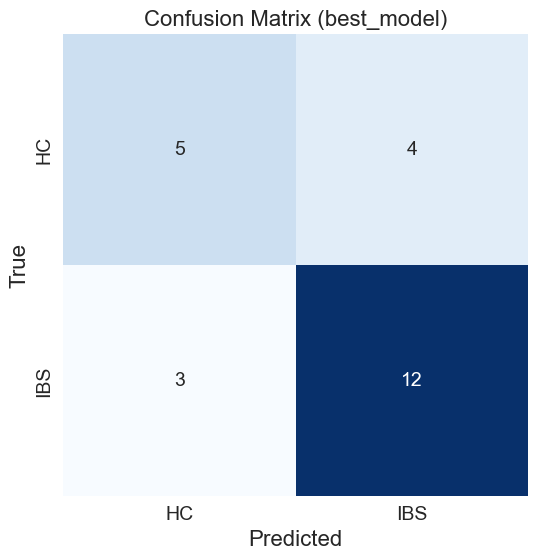

In [32]:
# Plot the confusion matrix from df_pred    

cm = confusion_matrix(df_pred_best['True'], df_pred_best['Predicted'], labels=['HC', 'IBS'])

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax, annot_kws={'size': 14})


ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (best_model)', fontsize=16)

ax.set_xticklabels(['HC', 'IBS'])
ax.set_yticklabels(['HC', 'IBS'])

# Increase tick labels size 
ax.tick_params(axis='both', which='major', labelsize=14)


# Increase xlabel and ylabel size
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)


plt.show()


In [33]:
# True Positive (TP)
TP = cm[1, 1]
# True Negative (TN)
TN = cm[0, 0]
# False Positive (FP)
FP = cm[0, 1]
# False Negative (FN)
FN = cm[1, 0]

print(f'TP (true positive i.e. IBS (1)) = {TP}\nTN (true negative i.e.  HC (0)) = {TN}\nFP (false pos.) = {FP}\nFN (false neg.) = {FN}\n')

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP)
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)

#F1-score
F1 = 2/((1/PPV) + (1/TPR))
#F1 = 2*TP /(2*TP+FP+FN)
#F1 = 2*PPV*TPR/(PPV+TPR)

# Matthews correlation coefficient
MCC = ((TP*TN)-(FP*FN)) /np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))

# Loop through the variables and print them with 2 decimals and preceede with variable name as string
var_names = ['TPR = TP/(TP+FN) (true positive rate, sensitivity, recall)', 
             'TNR = TN/(TN+FP) (true negative rate, specificity)', 
             'PPV = TP/(TP+FP) (positive predictive value, precision)', 
             'NPV = TN/(TN+FN) (negative predictive value)', 
             'FPR = FP/(FP+TN) (false positive rate)', 
             'FNR = FN/(TP+FN) (false negative rate)', 
             'FDR = FP/(TP+FP) (false discovery rate)', 
             'ACC = (TP+TN)/(TP+FP+FN+TN) (accuracy)',
             'F1 = 1/((1/PPV) + (1/TPR)) (F1-score, harmonic mean of precison and recall)',
             'MCC = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN))']
for i, var in enumerate([TPR, TNR, PPV, NPV, FPR, FNR, FDR, ACC, F1, MCC]):
    print(var_names[i],'=', "{:.2f}".format(var))

TP (true positive i.e. IBS (1)) = 12
TN (true negative i.e.  HC (0)) = 5
FP (false pos.) = 4
FN (false neg.) = 3

TPR = TP/(TP+FN) (true positive rate, sensitivity, recall) = 0.80
TNR = TN/(TN+FP) (true negative rate, specificity) = 0.56
PPV = TP/(TP+FP) (positive predictive value, precision) = 0.75
NPV = TN/(TN+FN) (negative predictive value) = 0.62
FPR = FP/(FP+TN) (false positive rate) = 0.44
FNR = FN/(TP+FN) (false negative rate) = 0.20
FDR = FP/(TP+FP) (false discovery rate) = 0.25
ACC = (TP+TN)/(TP+FP+FN+TN) (accuracy) = 0.71
F1 = 1/((1/PPV) + (1/TPR)) (F1-score, harmonic mean of precison and recall) = 0.77
MCC = ((TP*TN)-(FP*FN))/np.sqrt((TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)) = 0.37


In [34]:
print(df_pred.columns)
df_pred1.columns


MultiIndex([(      'BGA',),
            (    'p(HC)',),
            (   'p(IBS)',),
            ('Predicted',),
            (     'True',)],
           )


Index(['BGA', 'p(HC)', 'p(IBS)', 'Predicted', 'True'], dtype='object')

In [35]:
# Find BGA for each of the quadrants of the confusion matrix

BGA_TP = list(df_pred1[(df_pred1['Predicted'] == 'IBS') & (df_pred1['True'] == 'IBS')]['BGA'])
BGA_TN = list(df_pred1[(df_pred1['Predicted'] == 'HC') & (df_pred1['True'] == 'HC')]['BGA'])
BGA_FP = list(df_pred1[(df_pred1['Predicted'] == 'IBS') & (df_pred1['True'] == 'HC')]['BGA'])
BGA_FN = list(df_pred1[(df_pred1['Predicted'] == 'HC') & (df_pred1['True'] == 'IBS')]['BGA'])

print(f'BGA_TP: {BGA_TP} (n={len(BGA_TP)})')
print(f'BGA_TN: {BGA_TN} (n={len(BGA_TN)})')
print(f'BGA_FP: {BGA_FP} (n={len(BGA_FP)})')
print(f'BGA_FN: {BGA_FN} (n={len(BGA_FN)})')

# Find IBS-SSS in df_in  for which BGA is in BGA_TP
IBS_SSS_TP = df_in[df_in['BGA'].isin(BGA_TP)]['IBS-SSS']
IBS_SSS_TN = df_in[df_in['BGA'].isin(BGA_TN)]['IBS-SSS'] 
IBS_SSS_FP = df_in[df_in['BGA'].isin(BGA_FP)]['IBS-SSS']
IBS_SSS_FN = df_in[df_in['BGA'].isin(BGA_FN)]['IBS-SSS']

# Find summary statistics of IBS-SSS for each of the quadrants of the confusion matrix
print(f"TP (IBS-SSS mean (std)): {IBS_SSS_TP.mean().round(1)} (±{IBS_SSS_TP.std().round(1)})")
print(f"TN (IBS-SSS mean (std)): {IBS_SSS_TN.mean().round(1)} (±{IBS_SSS_TN.std().round(1)})")
print(f"FP (IBS-SSS mean (std)): {IBS_SSS_FP.mean().round(1)} (±{IBS_SSS_FP.std().round(1)})")
print(f"FN (IBS-SSS mean (std)): {IBS_SSS_FN.mean().round(1)} (±{IBS_SSS_FN.std().round(1)})")

# Find Sex in df_in  for which BGA is in BGA_TP
SEX_TP = df_in[df_in['BGA'].isin(BGA_TP)].groupby(['Sex'])
SEX_TN = df_in[df_in['BGA'].isin(BGA_TN)].groupby(['Sex']) 
SEX_FP = df_in[df_in['BGA'].isin(BGA_FP)].groupby(['Sex'])
SEX_FN = df_in[df_in['BGA'].isin(BGA_FN)].groupby(['Sex'])

# Find number of M and F in each of the quadrants of the confusion matrix

F_TP = SEX_TP['Sex'].count()[0]
M_TP = SEX_TP['Sex'].count()[1]

F_TN = SEX_TN['Sex'].count()[0]
M_TN = SEX_TN['Sex'].count()[1]

F_FP = SEX_FP['Sex'].count()[0]
M_FP = SEX_FP['Sex'].count()[1]

F_FN = SEX_FN['Sex'].count()[0]

try:
    if 'Sex' in SEX_FN and 1 in SEX_FN['Sex'].value_counts():
        M_FN = SEX_FN['Sex'].value_counts()[1]
    else:
        M_FN = 0
except NameError:
    M_FN = 0



BGA_TP: ['BGA_143', 'BGA_058', 'BGA_060', 'BGA_101', 'BGA_077', 'BGA_142', 'BGA_136', 'BGA_067', 'BGA_160', 'BGA_131', 'BGA_152', 'BGA_144'] (n=12)
BGA_TN: ['BGA_079', 'BGA_064', 'BGA_120', 'BGA_099', 'BGA_066'] (n=5)
BGA_FP: ['BGA_090', 'BGA_125', 'BGA_065', 'BGA_171'] (n=4)
BGA_FN: ['BGA_148', 'BGA_151', 'BGA_128'] (n=3)
TP (IBS-SSS mean (std)): 244.1 (±48.5)
TN (IBS-SSS mean (std)): 40.2 (±27.0)
FP (IBS-SSS mean (std)): 12.2 (±15.4)
FN (IBS-SSS mean (std)): 264.3 (±36.9)


## Figure 3: Confusion matrix with annotations

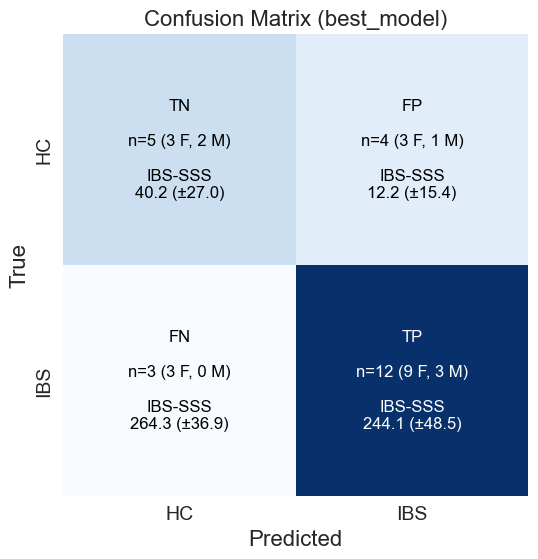

In [36]:
# Plot the confusion matrix from df_pred    

cm = confusion_matrix(df_pred_best['True'], df_pred_best['Predicted'], labels=['HC', 'IBS'])

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=False, ax=ax, annot_kws={'size': 14})


# Make placeholder text writing 3 lines of text in each center of the quadrant of the confusion matrix


# Coordinates for the text
coordinates = [(0, 0), (0, 1), (1, 0), (1, 1)]

texts = [f'TN\n\nn={len(BGA_TN)} ({F_TN} F, {M_TN} M)\n\nIBS-SSS\n{IBS_SSS_TN.mean().round(1)} (±{IBS_SSS_TN.std().round(1)})',
        f'FP\n\nn={len(BGA_FP)} ({F_FP} F, {M_FP} M)\n\nIBS-SSS\n{IBS_SSS_FP.mean().round(1)} (±{IBS_SSS_FP.std().round(1)})',
        f'FN\n\nn={len(BGA_FN)} ({F_FN} F, {M_FN} M)\n\nIBS-SSS\n{IBS_SSS_FN.mean().round(1)} (±{IBS_SSS_FN.std().round(1)})',
        f'TP\n\nn={len(BGA_TP)} ({F_TP} F, {M_TP} M)\n\nIBS-SSS\n{IBS_SSS_TP.mean().round(1)} (±{IBS_SSS_TP.std().round(1)})']
                                                                           
for text, (i, j) in zip(texts, coordinates):
    if (i==1 & j ==1):
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='white')
    else:
        plt.text(j + 0.5, i + 0.5, text, ha='center', va='center', color='black')


ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (best_model)', fontsize=16)

ax.set_xticklabels(['HC', 'IBS'])
ax.set_yticklabels(['HC', 'IBS'])

# Increase tick labels size 
ax.tick_params(axis='both', which='major', labelsize=14)


# Increase xlabel and ylabel size
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)


plt.show()

fig.savefig('../figs/Fig_3_best_model_confusion_matrix.png')

## Feature importance

Random Forest is a powerful ensemble learning method that operates by constructing a multitude of decision trees at training time and outputting the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees. One of its notable capabilities is the ability to assess the importance of features in a dataset with respect to the prediction task it is performing. Scikit-learn, a popular machine learning library in Python, provides tools to measure this feature importance in Random Forest models, offering insights into which features are contributing most to the model's predictions.

### Understanding Feature Importance

Feature importance in the context of a Random Forest model refers to a score assigned to each feature, indicating how useful or valuable each feature was in the construction of the decision trees within the model. The importance of a feature is directly linked to how much it contributes to reducing uncertainty or impurity in the data when making splits in the decision trees. The more a feature decreases the impurity, the more important it is considered to be.

### How Scikit-learn Calculates Feature Importance

Scikit-learn uses a straightforward method for calculating feature importance in Random Forest models, which can be summarized as follows:

1. **Impurity Decrease**: The core metric used by scikit-learn for calculating feature importance is the decrease in node impurity (e.g., Gini impurity for classification tasks, mean squared error for regression tasks) weighted by the probability of reaching that node. The node probability is estimated by the number of samples that pass through the node divided by the total number of samples. The feature importance of a specific feature is computed by aggregating the decrease in impurity over all the nodes where the feature is used to make a split, normalized by the sum of all feature importance scores to ensure they sum up to one.

2. **Aggregation Across Trees**: Since a Random Forest is comprised of many decision trees, scikit-learn averages the feature importance scores across all the trees in the forest to get a more robust estimate of the overall importance of each feature.

### Interpreting Feature Importance

- **High Importance**: Features with higher scores are considered more important for making predictions with the model. These features have a greater impact on the outcome of the model and are used more frequently or effectively to split the data in the trees.
  
- **Low Importance**: Conversely, features with lower scores are deemed less important and have a minimal impact on the model's predictions.

### Caveats and Considerations

While feature importance can provide valuable insights into your model, it's essential to approach the interpretation of these scores with a critical mindset:

- **Bias Towards High-Cardinality Features**: Random Forest's method of calculating feature importance can be biased towards numerical features with a high cardinality or categorical features with many levels. Such features may appear to be more important simply because they provide more unique split points, not necessarily because they are more predictive.

- **Correlated Features**: When features are highly correlated, the importance can be unevenly distributed among them, sometimes leading to misleading conclusions about the relative importance of correlated features.

- **Data Leakage**: Features with artificially high importance scores might be indicative of data leakage, where information from outside the training dataset is inadvertently used to make predictions, leading to overly optimistic performance estimates.



Feature importance in Random Forest models, as implemented in scikit-learn, provides a useful tool for understanding the influence of different features on the model's predictions. By analyzing these importance scores, one can gain insights into the data and the model's decision-making process. However, it's important to interpret these scores within the context of your dataset and model, considering potential biases and the dynamics of feature interactions.

The feature importance scores generated by a Random Forest model in scikit-learn are **derived from the model's training process**; thus, they are applied to and calculated based on the training set. During the training of the Random Forest, the algorithm evaluates how each feature contributes to the purity of the split (i.e., reducing impurity such as Gini impurity** for classification tasks or mean squared error for regression tasks) for each decision tree within the forest. The feature importance scores reflect the average effectiveness of each feature in improving the decision-making across all trees in the model.

### Key Points:
- **Training Set Application**: The calculation of feature importance is inherently tied to how the Random Forest model is built from the training data. It assesses the impact of each feature within the context of the model's learning process, specifically how well it helps to split the training data into more homogeneous or "pure" subsets.

- **Reflects Training Data Insights**: Because feature importance scores are based on the training data, they provide insights into which features were most informative for modeling the patterns within the training set. This can be crucial for understanding the model's behavior on data it was trained on.

- **Not Directly Applied to Test Set**: Feature importance scores do not directly reflect the model's performance or the importance of features on the test set. However, these scores can still be informative when evaluating the model's generalization to unseen data, as features deemed important during training are expected to play significant roles in predictions on new data.

### Practical Implications:
- **Model Interpretation**: Feature importance scores help in interpreting the model by identifying which features it relies on most for making predictions. This can inform feature selection and engineering efforts for model improvement.

- **Generalization Concerns**: While feature importance provides valuable insights, it's crucial to validate that the features deemed important during training also contribute effectively to the model's performance on unseen data (the test set). Discrepancies might suggest overfitting to the training data or the need for model adjustments.

- **Cross-validation**: To obtain a more robust assessment of feature importance that reflects both training and test performance, one might consider using techniques like cross-validation. This approach can help in understanding how feature importance varies across different subsets of the data and in assessing the model's generalization capability.

In summary, while the Random Forest feature importance is calculated based on the training data, its implications extend beyond, offering insights into model interpretation, feature relevance, and potential areas for improving model generalization.

In [37]:
importances = best_model.feature_importances_
importances.round(2)

array([0.05, 0.07, 0.06, 0.09, 0.21, 0.14, 0.19, 0.19])

In [38]:
list(df.columns)

['R1', 'R2', 'B1', 'B2', 'H1', 'H2', 'F1', 'F2', 'Group']

In [39]:
# Find index of those with highest importance, sorted from largest to smallest:
indices = np.argsort(importances)[::-1]
indices

array([4, 7, 6, 5, 3, 1, 2, 0])

In [40]:
# Find index of those with highest importance, sorted from smallest to largest:
indices = np.argsort(importances)
indices

array([0, 2, 1, 3, 5, 6, 7, 4])

In [41]:
features = df.drop('Group', axis=1)
for f in range(features.shape[1]): 
    print(f'{df.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

R1: 0.05
B1: 0.06
R2: 0.07
B2: 0.09
H2: 0.14
F1: 0.19
F2: 0.19
H1: 0.21


## Figure 4a: Feature importance (Gini impurity)

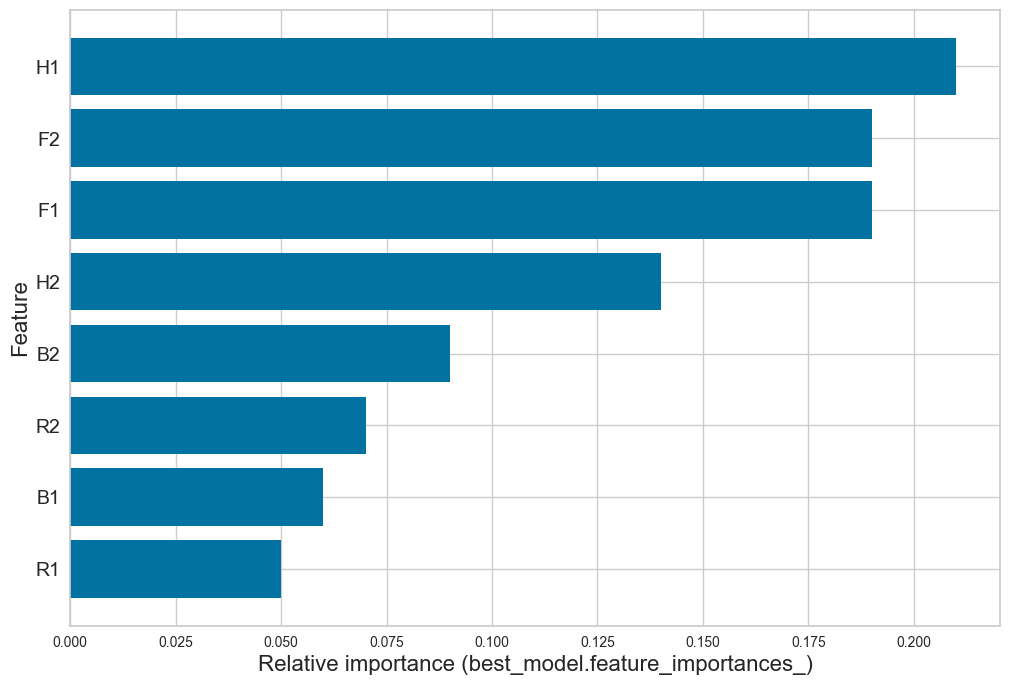

In [42]:
# Let's plot these results in a bar chart in descending order of importance
f, ax = plt.subplots(figsize=(12,8))
plt.barh(features.columns[indices], np.round(importances[indices],2))
plt.xlabel("Relative importance (best_model.feature_importances_)", fontsize=16)
plt.ylabel("Feature", fontsize=16)

# Increase font of ytick labels to make them easier to read
plt.yticks(fontsize=14)

plt.show()

f.savefig('../figs/Fig_4a_best_model_feature_importances_.png')


The H1 scores has the largest explanatory value, followed by F2. It is not hard to imagine that this kind of information is beneficial in practice. However, it is something that must be used carefully, as the feature importances derived from a single model can be quite misleading.

Feature importances in the random forest classification models of scikit-learn are based on measuring how efficient each feature is in reducing uncertainty (the so-called impurity in random forests). Unfortunately, this often results in an incorrect estimate of how important each feature actually is (see https://explained.ai/rf-importance/index.html for a deep-dive into this issue).

A more robust technique is what is called permutation importance.

### Permutation importance

Permutation importance is a model-agnostic method to measure feature importance. It works by randomly shuffling the values of each feature and measuring how much this shuffling decreases the model's performance. The idea behind permutation importance is that if a feature is important for the predictions of a trained model, then a random shuffling of the data in the corresponding column should drastically reduce the model's accuracy. On the other hand, a random shuffling of an unimportant feature shouldn't impact the model much.

This method has several advantages:

- It's model-agnostic, meaning it can be used with any type of model, not just random forests.
- It takes into account feature interactions, unlike some other importance measures.
- It provides a measure of uncertainty through the standard deviation of importance scores.

NOTE: Different measurement methods:

- Gini impurity: This is calculated during the training of the Random Forest. It measures how often a randomly chosen element from the set would be incorrectly labeled if it were randomly labeled according to the distribution of labels in the subset.
- Permutation importance: This is calculated after the model is trained. It measures how much the model's performance decreases when a feature is randomly shuffled.

In [43]:
X_test = get_config('X_test')
y_true = list(get_config('y_test'))
pred_best = predict_model(best_model);
# y_pred = best_model.predict(X_test)  # HC=0, IBS=1
y_pred = list(df_pred_best['Predicted'])
# y_pred = list(pred_best['prediction_label']) 
n_repeats = 30 
random_state = 123
X = df.drop('Group', axis=1)

y_pred_numeric = [0 if x == 'HC' else 1 for x in y_pred]
y_true_numeric = [0 if x == 'HC' else 1 for x in y_true]



,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7083,0.7778,0.7083,0.7031,0.7045,0.3636,0.3651


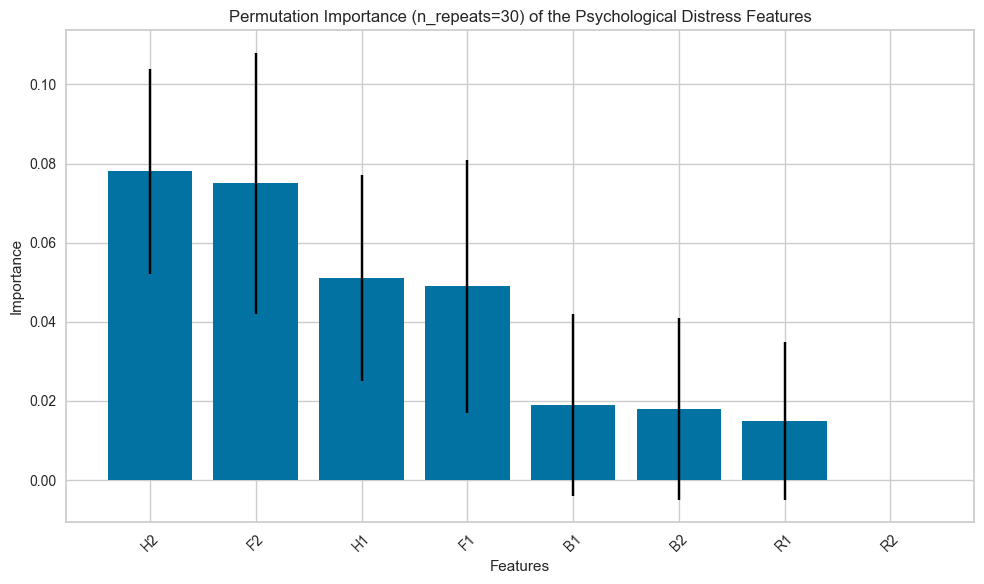

  feature  importance    std
5      H2       0.078  0.026
7      F2       0.075  0.033
4      H1       0.051  0.026
6      F1       0.049  0.032
2      B1       0.019  0.023
3      B2       0.018  0.023
0      R1       0.015  0.020
1      R2       0.000  0.000


In [44]:
# Calculate permutation importance
result = permutation_importance(best_model, X_test, y_pred_numeric, n_repeats=30, random_state=123)

# Create a dataframe of feature importances
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': result.importances_mean.round(3),
    'std': result.importances_std.round(3)
}).sort_values('importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.bar(feature_importance['feature'], feature_importance['importance'])
plt.errorbar(feature_importance['feature'], feature_importance['importance'], 
             yerr=feature_importance['std'], fmt='none', c='black')
plt.title(f'Permutation Importance (n_repeats={n_repeats}) of the Psychological Distress Features')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print(feature_importance)

In [45]:
# Check model performance
from sklearn.metrics import accuracy_score

# Assuming you have a test set (validation set)
X_val = get_config('X_test')
y_val = y_true_numeric

# Predict on validation set
y_pred = best_model.predict(X_val)

# Calculate accuracy
accuracy = accuracy_score(y_val, y_pred)
print(f"Model Accuracy: {np.round(accuracy,3)}")

# Inspect the data
print("X_train sample:\n", get_config('X_train').head())
print("y_train sample:\n", get_config('y_train')[:5])

# Verify permutation importance calculation
from sklearn.inspection import permutation_importance

r_perm = permutation_importance(best_model, get_config('X_test'), y_pred_numeric, n_repeats=30, random_state=123)
print("Permutation Importance:", r_perm.importances_mean.round(3))

Model Accuracy: 0.708
X_train sample:
       R1    R2   B1    B2    H1   H2   F1   F2
74  40.0  66.0  2.0   3.0  11.0  7.0  3.0  0.0
21  32.0  60.0  0.0   1.0   0.0  0.0  0.0  0.0
50  35.0  66.0  1.0   7.0   6.0  3.0  0.0  0.0
51  14.0  35.0  9.0  11.0  12.0  6.0  7.0  4.0
55  27.0  60.0  2.0  14.0   9.0  4.0  2.0  1.0
y_train sample:
 74     HC
21     HC
50     HC
51    IBS
55    IBS
Name: Group, dtype: category
Categories (2, object): ['HC', 'IBS']
Permutation Importance: [0.015 0.    0.019 0.018 0.051 0.078 0.049 0.075]


In [46]:
# Results of permutation importance calculation (mean +/- std)

for i in r_perm.importances_mean.argsort()[::-1]:
    print(f"{features.columns[i]:<8}"
    f"{r_perm.importances_mean[i]:.3f}"
    f" +/- {r_perm.importances_std[i]:.3f}")

H2      0.078 +/- 0.026
F2      0.075 +/- 0.033
H1      0.051 +/- 0.026
F1      0.049 +/- 0.032
B1      0.019 +/- 0.023
B2      0.018 +/- 0.023
R1      0.015 +/- 0.020
R2      0.000 +/- 0.000


### Recursive Feature Elimination, RFE

Feature Ranking:
  feature  ranking
6      F1        1
4      H1        2
7      F2        3
5      H2        4
3      B2        5
1      R2        6
2      B1        7
0      R1        8


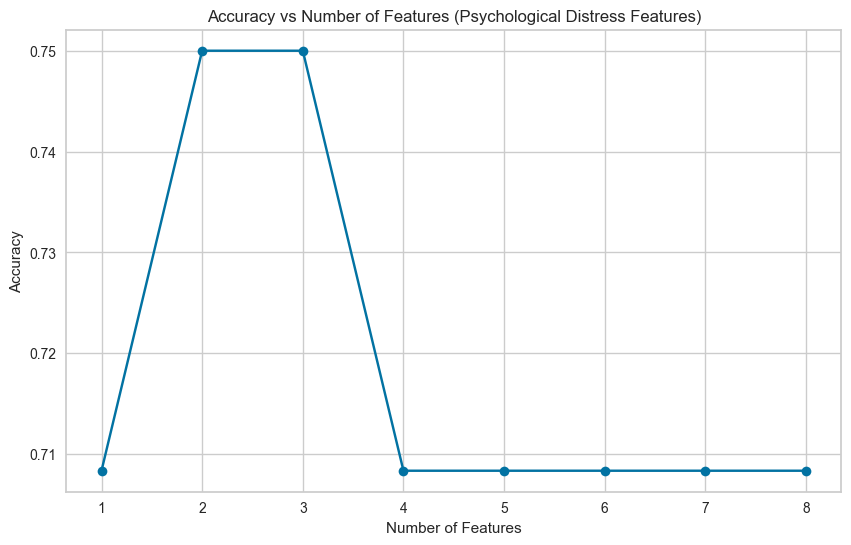


Optimal number of features: 2
Optimal features: ['F1', 'H1']

Final model accuracy with 2 features: 0.7500


In [47]:
X_train = get_config('X_train')
X_test = get_config('X_test')

y_train = get_config('y_train')
y_test = get_config('y_test')


# Perform Recursive Feature Elimination
n_features_to_select = 1
rfe = RFE(estimator=best_model, n_features_to_select=n_features_to_select, step=1)
rfe = rfe.fit(X_train, y_train)

# Get the feature ranking
feature_ranking = pd.DataFrame({
    'feature': X.columns,
    'ranking': rfe.ranking_
}).sort_values('ranking')

print("Feature Ranking:")
print(feature_ranking)

# Evaluate models with different numbers of features
n_features = range(1, len(X.columns) + 1)
accuracies = []

for n in n_features:
    rfe_n = RFE(estimator=best_model, n_features_to_select=n, step=1)
    X_train_n = rfe_n.fit_transform(X_train, y_train)
    X_test_n = rfe_n.transform(X_test)
    
    best_model.fit(X_train_n, y_train)
    y_pred = best_model.predict(X_test_n)
    accuracies.append(accuracy_score(y_test, y_pred))

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(n_features, accuracies, marker='o')
plt.title('Accuracy vs Number of Features (Psychological Distress Features)')
plt.xlabel('Number of Features')
plt.ylabel('Accuracy')
plt.xticks(n_features)
plt.grid(True)
plt.show()

# Identify the optimal number of features
optimal_n_features = n_features[np.argmax(accuracies)]
print(f"\nOptimal number of features: {optimal_n_features}")

# Get the names of the optimal features
optimal_features = feature_ranking['feature'][:optimal_n_features].tolist()
print(f"Optimal features: {optimal_features}")

# Train the final model with optimal features
rfe_optimal = RFE(estimator=best_model, n_features_to_select=optimal_n_features, step=1)
X_train_optimal = rfe_optimal.fit_transform(X_train, y_train)
X_test_optimal = rfe_optimal.transform(X_test)

rf_final = RandomForestClassifier(n_estimators=100, random_state=123)
rf_final.fit(X_train_optimal, y_train)

# Evaluate the final model
y_pred_final = rf_final.predict(X_test_optimal)
final_accuracy = accuracy_score(y_test, y_pred_final)
print(f"\nFinal model accuracy with {optimal_n_features} features: {final_accuracy:.4f}")

## SHAP values

**SHAP (SHapley Additive exPlanations) values** provide a powerful and unified framework to interpret machine learning model predictions, particularly in terms of feature importance. Developed based on [cooperative game theory](https://en.wikipedia.org/wiki/Cooperative_game_theory), SHAP values offer a way to understand the contribution of each feature to the prediction of a specific instance, making them highly useful in fields like medical AI where interpretability is crucial.


<img src="https://shap.readthedocs.io/en/latest/_images/shap_header.png" width="600" />
 

### Fundamentals of SHAP Values

1. **Game Theory Background**: SHAP values are derived from Shapley values in game theory, which are a method to fairly distribute the 'payout' (or contribution) among players (features) in a coalition (model).


2. **Individual Prediction Explanation**: SHAP values explain the prediction of an instance by computing the contribution of each feature to the prediction. Unlike global feature importance, which gives an overall picture, SHAP values provide local interpretability for each prediction.

3. **Additive Feature Attribution**: In SHAP, the model's output is expressed as the sum of the effects of each feature being introduced into a conditional expectation.

### How SHAP Values Work in Practice

- **Model Agnostic**: SHAP can be applied to any machine learning model, be it a simple linear model or a complex deep learning model.

- **Computing SHAP Values**: For a given prediction, SHAP values are calculated by comparing what a model predicts with and without each feature. However, since features can be interdependent, this is done in a way that accounts for all possible combinations of features.

- **Interpretation**: A SHAP value for a feature for a particular prediction represents how much knowing the feature's value moves the prediction away from the mean prediction for the dataset.

### Significance in Medical AI

- **Insight into Model Predictions**: SHAP values can reveal why a model makes certain decisions, which is vital in healthcare settings where understanding the rationale behind a diagnosis or treatment recommendation is as important as the accuracy of the prediction itself.

- **Patient-Specific Explanations**: They can provide personalized insights, like why a particular patient was classified as high risk for a disease.

- **Clinical Research and Decision Making**: Helps in identifying and understanding key factors that drive medical conditions, which can be instrumental in both clinical research and decision-making.

### Example

Imagine a model predicting diabetes risk. The SHAP value for a feature like 'blood sugar level' in a particular patient's prediction tells us how much having that specific blood sugar level, compared to the average level in the training data, impacts the model's risk prediction for that patient.

### Challenges and Considerations

- **Complexity and Computation**: Calculating SHAP values, especially for models with a large number of features or complex interactions, can be computationally intensive.

- **Interpretation Nuances**: While SHAP values offer clarity, interpreting them, especially in the context of complex interactions and correlations between features, requires domain expertise.

In conclusion, SHAP values represent a significant advancement in the field of explainable AI, offering clear, detailed, and theoretically grounded insights into model predictions. This is especially critical in medical AI, where transparent and interpretable AI models are crucial for clinical acceptance and ethical considerations.

Cooperative game theory comes into play in the concept of SHAP (SHapley Additive exPlanations) values through the use of Shapley values, which are a solution concept from cooperative game theory. To understand this, let's first delve into what cooperative game theory is and then see how it relates to SHAP values in machine learning.

### Cooperative Game Theory

1. **Basic Concept**: Cooperative game theory deals with how groups of agents (players) can form coalitions and how the payoff (rewards) from any cooperative effort should be distributed among these agents.

2. **Coalitions and Payoffs**: The key focus is on the formation of groups (coalitions) and how the rewards from collaborative efforts are allocated to the members of the coalition.

3. **Shapley Values**: Developed by Lloyd Shapley, the Shapley value is a method to fairly distribute the total gains (or losses) among the players based on their individual contributions. The idea is to find an equitable distribution of payoffs, considering all possible combinations of coalition formation.

### SHAP Values and Cooperative Game Theory

1. **Model as a Cooperative Game**: In the context of SHAP values, each feature in a machine learning model is considered a 'player' in a game. The 'game' is the task of making a prediction, and the 'payoff' is the prediction itself.

2. **Feature Contributions**: The Shapley value calculates the contribution of each feature (player) to the prediction (payoff) by considering all possible combinations of features. It averages the marginal contributions of a feature across all possible combinations.

3. **Fair Allocation of Importance**: Just like Shapley values in game theory aim to distribute payoffs fairly based on contribution, SHAP values in machine learning aim to distribute the 'credit' or 'blame' of a prediction among the features based on their contribution.

### Practical Example

Imagine a model predicting patient health outcomes based on various features like age, weight, blood pressure, etc. The SHAP value for each feature tells us how much that feature contributes to a particular prediction, considering the interplay with other features. This is akin to determining how much each player (feature) in a game (the model) contributes to the final score (prediction), considering all possible team (feature combination) scenarios.

### Significance

- **Fairness and Equity**: Just as Shapley values in game theory ensure a fair distribution of rewards, SHAP values in machine learning ensure a fair attribution of importance to features.
- **Interpretability and Transparency**: This approach allows for a more nuanced and transparent interpretation of model predictions, which is especially valuable in critical fields like medical AI.

In summary, cooperative game theory, through the concept of Shapley values, provides a foundational framework for SHAP values in machine learning, ensuring a fair and equitable attribution of feature contributions to model predictions. This intersection of game theory and AI highlights the multidisciplinary nature of advancements in AI interpretability.

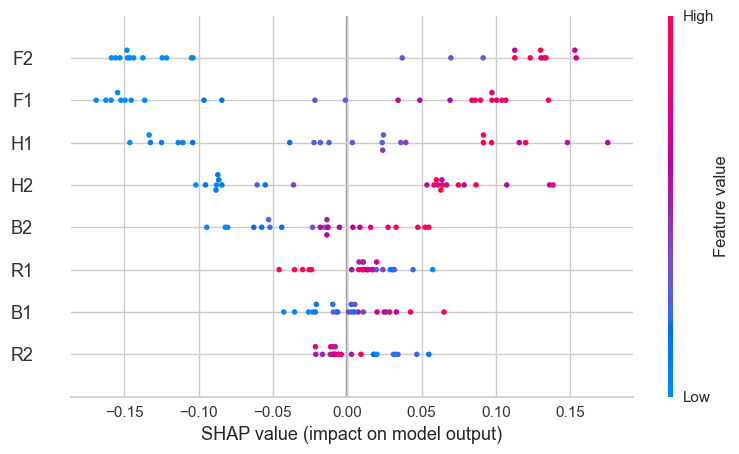

<Figure size 800x550 with 0 Axes>

In [48]:
# Assuming best_model is your trained Random Forest model
# and get_config('X_test') returns your test data

# Compute the SHAP values for the test set
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(get_config('X_test'))

# For classification problems, shap_values will be a list of arrays
# (one per class). We need to choose which class to plot.
# Let's assume we want to plot for the IBS class (index 1)

# Plot the SHAP values
f, ax = plt.subplots(figsize=(12,8))
shap.summary_plot(shap_values[:, :, 1], get_config('X_test'))
plt.tight_layout()

plt.show()

f.savefig('../figs/Fig_4b_shap_values_for_class_ibs_in_test_set.png')

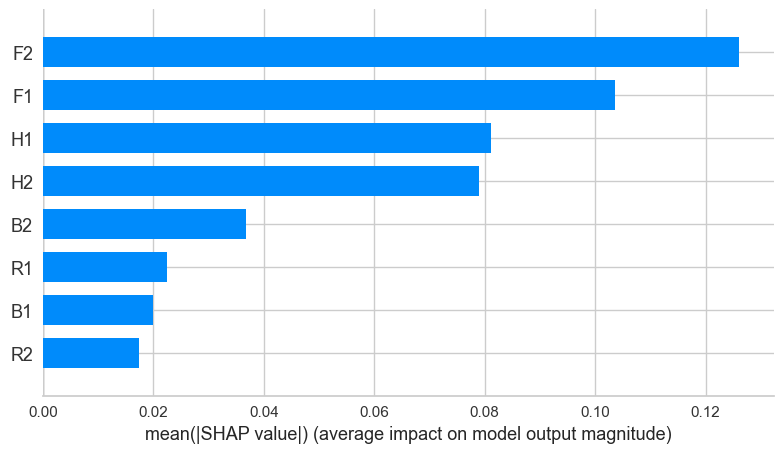

In [49]:
# Assuming best_model is your trained Random Forest model
# and get_config('X_test') returns your test data

# Compute the SHAP values for the test set
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(get_config('X_test'))

# For classification problems, shap_values will be a list of arrays
# (one per class). We need to choose which class to plot.
# Let's assume we want to plot for the IBS class (index 1)

# Plot the SHAP values
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values[:, :, 1], get_config('X_test'), plot_type="bar", show=False)
plt.tight_layout()
plt.show()

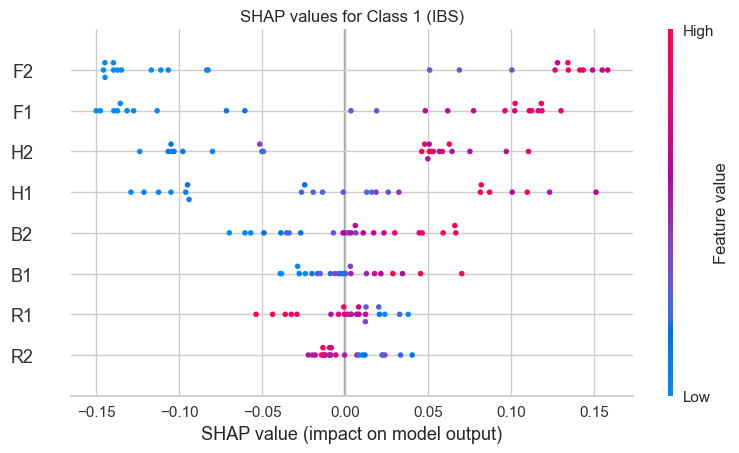

In [50]:
# compute SHAP values
explainer = shap.Explainer(best_model, get_config('X_test'))
shap_values = explainer(get_config('X_test'))

class_of_interest = 1  # Change this to the class you're interested in
plt.figure(figsize=(12, 8))
shap.plots.beeswarm(shap_values[:, :, class_of_interest], show=False)
plt.title(f"SHAP values for Class {class_of_interest} (IBS)")
plt.tight_layout()
plt.show()


In [51]:
?shap_values

Type:        Explanation
String form:
.values =
           array([[[ 6.45833291e-04, -6.45833248e-04],
           [ 2.23611108e-02, -2.23611105e-02], <...> ,  3., 13.,  8.,  2.,  2.,  1.],
           [41., 68.,  3.,  9.,  3.,  0.,  0.,  0.]], dtype=float32)
Length:      24
File:        ~/opt/anaconda3/envs/ibs/lib/python3.11/site-packages/shap/_explanation.py
Docstring:   A sliceable set of parallel arrays representing a SHAP explanation.

In [52]:
# Step 4: Cross-Validation
#cv_scores = cross_val_score(best_model, X_test, y_test, cv=10)
#print("Cross-Validation Scores:", cv_scores)
#print("Average 10-Fold CV Score:", np.mean(cv_scores))

## Exploring how far we can get with the RF model


 --> Create and run an rf model:

 --> Tune the rf model:


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6667,0.8750,0.6667,0.6667,0.6667,0.2500,0.2500
1,0.8333,1.0000,0.8333,0.8889,0.8381,0.6667,0.7071
2,0.8333,0.8750,0.8333,0.8889,0.8381,0.6667,0.7071
3,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
4,0.8000,0.6667,0.8000,0.8500,0.7810,0.5455,0.6124
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.8000,1.0000,0.8000,0.8500,0.7810,0.5455,0.6124
7,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
8,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).

 --> Plot the tuned_rf model:


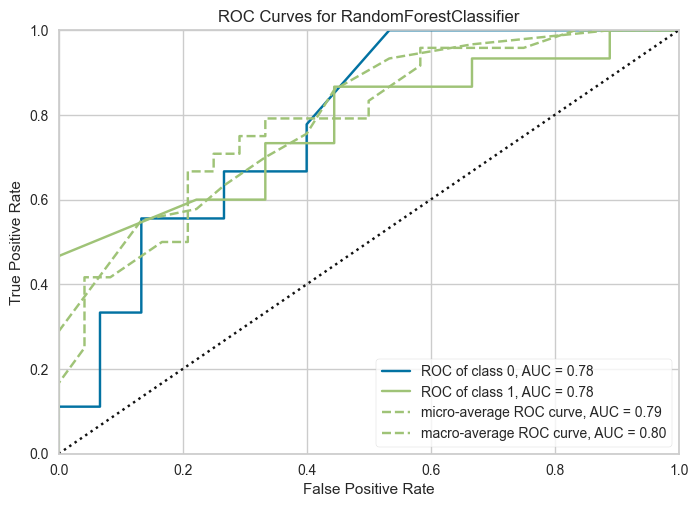


 --> Evaluate the tuned_rf model:


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…


 --> Model prediction with the tuned_rf model:


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7083,0.7778,0.7083,0.7031,0.7045,0.3636,0.3651



 --> Finalized tuned_rf model:

 --> Saving the tuned_rf model Final_tuned_RF_Model_20240721.pkl to ../models:
Transformation Pipeline and Model Successfully Saved
CPU times: user 2.66 s, sys: 309 ms, total: 2.97 s
Wall time: 5.63 s


(Pipeline(memory=Memory(location=None),
          steps=[('label_encoding',
                  TransformerWrapperWithInverse(exclude=None, include=None,
                                                transformer=LabelEncoder())),
                 ('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['R1', 'R2', 'B1', 'B2', 'H1', 'H2',
                                              'F1', 'F2'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               m...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                         class_weight=None, criterion='

In [53]:
%%time

# Run the rf model
print(f'\n --> Create and run an rf model:')
rf = best_model # create_model('rf')

# Tune the rf model
print(f'\n --> Tune the rf model:')
tuned_rf = tune_model(rf)

# Plot the model
print(f'\n --> Plot the tuned_rf model:')
plot_model(tuned_rf, plot = 'auc')

# Evaluate the model
print(f'\n --> Evaluate the tuned_rf model:')
evaluate_model(tuned_rf)

# Predict the model
print(f'\n --> Model prediction with the tuned_rf model:')
predict_model(tuned_rf)

# Finalize the model
print(f'\n --> Finalized tuned_rf model:')
final_rf = finalize_model(tuned_rf)

# Save the model in ../models
rf_model_name = 'Final_tuned_RF_Model_20240721'
print(f'\n --> Saving the tuned_rf model {rf_model_name}.pkl to ../models:')
save_model(final_rf, f'../models/{rf_model_name}')



In [54]:
# Load the model
rf_model_name = 'Final_tuned_RF_Model_20240721'
print(f'--> Loading the tuned_rf model:{rf_model_name}:')
loaded_rf = load_model(f'../models/{rf_model_name}')

# Inspect the model object
print(f'Inspecting the loaded_rf model:')
print(loaded_rf)

--> Loading the tuned_rf model:Final_tuned_RF_Model_20240721:
Transformation Pipeline and Model Successfully Loaded
Inspecting the loaded_rf model:
Pipeline(memory=FastMemory(location=/var/folders/y0/6krmxw152qjflvfhkn0bn4r40000gn/T/joblib),
         steps=[('label_encoding',
                 TransformerWrapperWithInverse(exclude=None, include=None,
                                               transformer=LabelEncoder())),
                ('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['R1', 'R2', 'B1', 'B2', 'H1', 'H2',
                                             'F1', 'F2'],
                                    transformer=SimpleImputer(add_indicator=Fals...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=None, max_features='sqrt',
                                   

In [55]:
print(f'\n --> Model prediction with the tuned_rf model:')
pred_model = predict_model(loaded_rf)
pred_model


 --> Model prediction with the tuned_rf model:


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000


,R1,R2,B1,B2,H1,H2,F1,F2,Group,prediction_label,prediction_score
62,35.0,60.0,4.0,2.0,3.0,1.0,0.0,0.0,IBS,IBS,0.71
57,27.0,59.0,7.0,4.0,6.0,7.0,4.0,0.0,IBS,IBS,0.93
28,39.0,45.0,6.0,9.0,5.0,0.0,6.0,2.0,HC,HC,0.65
3,37.0,51.0,8.0,12.0,7.0,7.0,7.0,4.0,IBS,IBS,1.00
20,40.0,55.0,2.0,4.0,3.0,1.0,0.0,0.0,HC,HC,0.97
5,32.0,72.0,5.0,10.0,7.0,4.0,7.0,3.0,IBS,IBS,0.96
65,37.0,52.0,1.0,5.0,4.0,1.0,0.0,0.0,IBS,IBS,0.67
47,28.0,65.0,6.0,10.0,1.0,1.0,6.0,0.0,IBS,IBS,0.82
7,33.0,59.0,0.0,5.0,3.0,1.0,0.0,0.0,HC,HC,0.97
36,35.0,55.0,3.0,11.0,13.0,4.0,5.0,0.0,IBS,IBS,0.95


In [56]:
pred_model.shape

(24, 11)

In [57]:
# Make the pred_model a dataframe where the index is a separate columns denoted BGA
BGA_list = list(pred_model.index)

df_tuned_pred = pd.DataFrame()
#df_tuned_pred = pred_model.reset_index().copy()
df_tuned_pred['BGA'] = BGA_list

# Reset index in pred_model
pred_model = pred_model.reset_index(drop=True)

# Add the columns of pred_model to df_tuned_pred
for col in pred_model.columns:
    df_tuned_pred[col] = pred_model[col]

# Rename the columns
df_tuned_pred = df_tuned_pred.rename(columns = {'Group': 'True', 'prediction_label': 'Predicted', 'prediction_score': 'max(p(HC),p(IBS))'})
df_tuned_pred



,BGA,R1,R2,B1,B2,H1,H2,F1,F2,True,Predicted,"max(p(HC),p(IBS))"
0,62,35.0,60.0,4.0,2.0,3.0,1.0,0.0,0.0,IBS,IBS,0.71
1,57,27.0,59.0,7.0,4.0,6.0,7.0,4.0,0.0,IBS,IBS,0.93
2,28,39.0,45.0,6.0,9.0,5.0,0.0,6.0,2.0,HC,HC,0.65
3,3,37.0,51.0,8.0,12.0,7.0,7.0,7.0,4.0,IBS,IBS,1.00
4,20,40.0,55.0,2.0,4.0,3.0,1.0,0.0,0.0,HC,HC,0.97
5,5,32.0,72.0,5.0,10.0,7.0,4.0,7.0,3.0,IBS,IBS,0.96
6,65,37.0,52.0,1.0,5.0,4.0,1.0,0.0,0.0,IBS,IBS,0.67
7,47,28.0,65.0,6.0,10.0,1.0,1.0,6.0,0.0,IBS,IBS,0.82
8,7,33.0,59.0,0.0,5.0,3.0,1.0,0.0,0.0,HC,HC,0.97
9,36,35.0,55.0,3.0,11.0,13.0,4.0,5.0,0.0,IBS,IBS,0.95


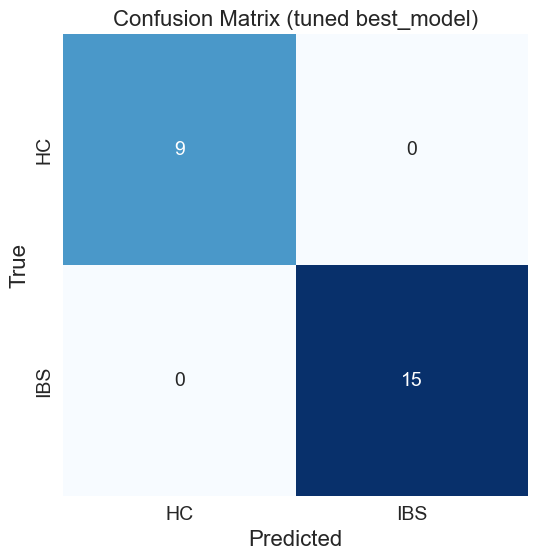

In [58]:
# Plot the confusion matrix from df_pred    

cm = confusion_matrix(df_tuned_pred['True'], df_tuned_pred['Predicted'], labels=['HC', 'IBS'])

fig, ax = plt.subplots(figsize=(6, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax, annot_kws={'size': 14})


ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix (tuned best_model)', fontsize=16)

ax.set_xticklabels(['HC', 'IBS'])
ax.set_yticklabels(['HC', 'IBS'])

# Increase tick labels size 
ax.tick_params(axis='both', which='major', labelsize=14)


# Increase xlabel and ylabel size
ax.xaxis.label.set_size(16)
ax.yaxis.label.set_size(16)


plt.show()

In [59]:
# Feature importance
importances = loaded_rf.feature_importances_
importances.round(2)

array([0.1 , 0.09, 0.1 , 0.09, 0.14, 0.13, 0.21, 0.13])

In [60]:
# Find index of those with highest importance, sorted from smallest to largest:
indices = np.argsort(importances)
indices

array([1, 3, 2, 0, 5, 7, 4, 6])

In [61]:
features = df.drop('Group', axis=1)
for f in range(features.shape[1]): 
    print(f'{df.columns[indices[f]]}: {np.round(importances[indices[f]],2)}')

R2: 0.09
B2: 0.09
B1: 0.1
R1: 0.1
H2: 0.13
F2: 0.13
H1: 0.14
F1: 0.21


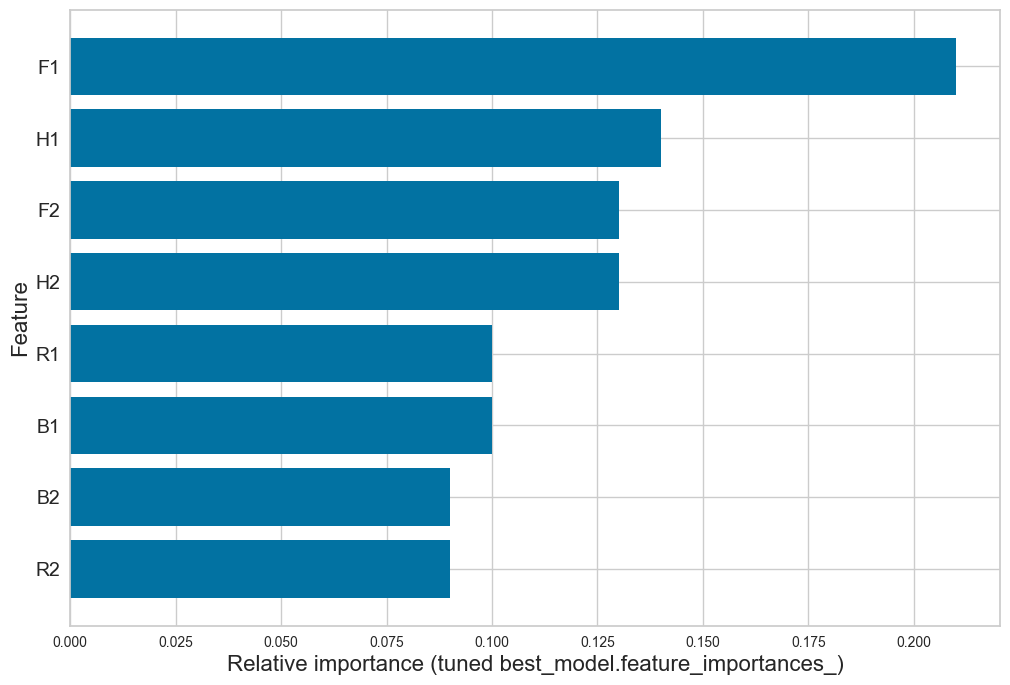

In [62]:
# Let's plot these results in a bar chart in descending order of importance
f, ax = plt.subplots(figsize=(12,8))
plt.barh(features.columns[indices], np.round(importances[indices],2))
plt.xlabel("Relative importance (tuned best_model.feature_importances_)", fontsize=16)
plt.ylabel("Feature", fontsize=16)

# Increase font of ytick labels to make them easier to read
plt.yticks(fontsize=14)

plt.show()

In [63]:
%%time
r_tuned = permutation_importance(loaded_rf, get_config('X_train'), list(get_config('y_train')), n_repeats=30, random_state=123)
#r_tuned

CPU times: user 17.1 s, sys: 6.43 s, total: 23.6 s
Wall time: 23.4 s


On X_test, we get the following permutation importance results:
```python
F1      0.107 +/- 0.047
R2      0.089 +/- 0.035
R1      0.081 +/- 0.040
H2      0.060 +/- 0.028
F2      0.037 +/- 0.035
B2      0.035 +/- 0.029
B1      0.035 +/- 0.027
H1      0.033 +/- 0.029
```

On X_train, we get the following permutation importance results:
```python
F1      0.087 +/- 0.028
F2      0.036 +/- 0.018
H1      0.029 +/- 0.026
H2      0.022 +/- 0.015
B1      0.017 +/- 0.013
B2      0.010 +/- 0.011
R1      0.004 +/- 0.008
R2      0.000 +/- 0.000
```

In [64]:
# Results
for i in r_tuned.importances_mean.argsort()[::-1]:
    print(f"{features.columns[i]:<8}"
    f"{r_tuned.importances_mean[i]:.3f}"
    f" +/- {r_tuned.importances_std[i]:.3f}")

F1      0.087 +/- 0.028
F2      0.036 +/- 0.018
H1      0.029 +/- 0.026
H2      0.022 +/- 0.015
B1      0.017 +/- 0.013
B2      0.010 +/- 0.011
R1      0.004 +/- 0.008
R2      0.000 +/- 0.000


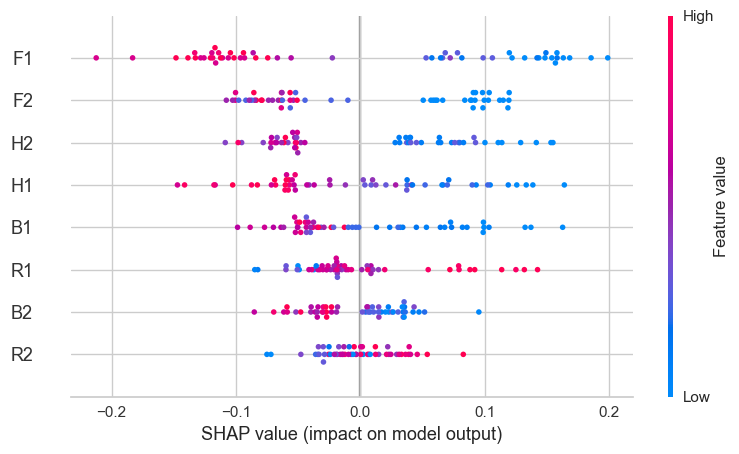

==== COMPUTING SHAP VALUES IN THE TRAINING SET ====


In [65]:
# Assuming the last step of your pipeline is a tree-based model
tree_model = loaded_rf.steps[-1][1]

# Create object that can calculate shap values
explainer = shap.TreeExplainer(tree_model)

# Calculate Shap values
shap_values = explainer.shap_values(get_config('X_train'))  # X_test)

# Make plot. Index of [1] is explained in text below.
f1, ax = plt.subplots(figsize=(12,8))

f1 = shap.summary_plot(shap_values[:, :, 0], get_config('X_train'))  # X_test)

print('==== COMPUTING SHAP VALUES IN THE TRAINING SET ====')    

plt.show()

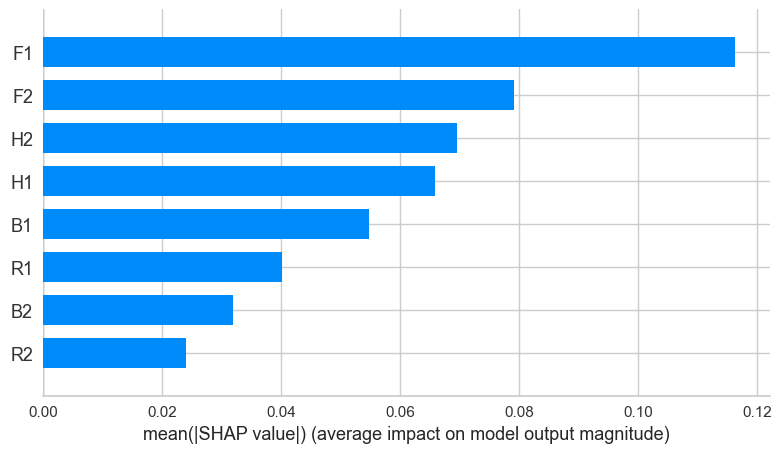

==== COMPUTING SHAP VALUES IN THE TRAINING SET ====


In [66]:
f2, ax = plt.subplots(figsize=(12,8))

f2 = shap.summary_plot(shap_values[:, :, 0], get_config('X_train'), plot_type="bar")   # X_test

print('==== COMPUTING SHAP VALUES IN THE TRAINING SET ====') 

plt.show()